In [3]:
#### Tools and Dependencies
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from google.colab import files
import os, zipfile
import numpy as np
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)


In [2]:
#### getting the datasets

!git clone --no-checkout https://github.com/Agasthya-Samyak-Jnan/Diabetic-Neuropathy-Risk-ML.git
%cd Diabetic-Neuropathy-Risk-ML
!git sparse-checkout init --cone
!git sparse-checkout set Datasets/Extended_Dataset
!git checkout main

Cloning into 'Diabetic-Neuropathy-Risk-ML'...
remote: Enumerating objects: 27370, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 27370 (delta 1), reused 1 (delta 1), pack-reused 27367 (from 2)
Receiving objects: 100% (27370/27370), 1.27 GiB | 45.51 MiB/s, done.
Resolving deltas: 100% (1011/1011), done.
/content/Diabetic-Neuropathy-Risk-ML
Updating files: 100% (27991/27991), done.
Already on 'main'
Your branch is up to date with 'origin/main'.


In [4]:
### Config parameters

IMG_SIZE = 240            # REQUIRED for EfficientNet-B1
MODEL_NAME = "EfficientNet-B1"
VERSION = "Version-01"

train_dir = "Datasets/Extended_Dataset/train"
val_dir   = "Datasets/Extended_Dataset/val"


In [7]:
### Hyperparameters

BATCH_SIZE = 64
LR = 5e-5                   # Lower than B0
FT_LR = 1e-5                # Fine-tuning LR
EPOCHS = 10
FT_EPOCHS = 5               # Keep smaller to avoid overfitting

DROPOUT_RATE = 0.5          # Strong regularization

tf.random.set_seed(42)
np.random.seed(42)

In [6]:
#### Prepare Datasets

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="binary",
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)


Found 21660 files belonging to 2 classes.
Found 6330 files belonging to 2 classes.


In [16]:
#### Model Architecture

# Define Model
base_model = EfficientNetB1(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Freeze base model for Phase 1 training
base_model.trainable = False

# Custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)          # Slightly higher dropout than B0
output = Dense(1, activation="sigmoid")(x)

# Final model
model = Model(inputs=base_model.input, outputs=output)


In [17]:
#### initializing the model

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)


In [10]:
#### Phase 1

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/10
677/677 ━━━━━━━━━━━━━━━━━━━━ 147s 155ms/step - accuracy: 0.6074 - auc: 0.6508 - loss: 0.6593 - val_accuracy: 0.8637 - val_auc: 0.9133 - val_loss: 0.4366
Epoch 2/10
677/677 ━━━━━━━━━━━━━━━━━━━━ 61s 90ms/step - accuracy: 0.8015 - auc: 0.8856 - loss: 0.4601 - val_accuracy: 0.8752 - val_auc: 0.9194 - val_loss: 0.3702
Epoch 3/10
677/677 ━━━━━━━━━━━━━━━━━━━━ 53s 78ms/step - accuracy: 0.8418 - auc: 0.9243 - loss: 0.3827 - val_accuracy: 0.8810 - val_auc: 0.9231 - val_loss: 0.3425
Epoch 4/10
677/677 ━━━━━━━━━━━━━━━━━━━━ 54s 80ms/step - accuracy: 0.8537 - auc: 0.9333 - loss: 0.3504 - val_accuracy: 0.8821 - val_auc: 0.9251 - val_loss: 0.3283
Epoch 5/10
677/677 ━━━━━━━━━━━━━━━━━━━━ 57s 84ms/step - accuracy: 0.8664 - auc: 0.9454 - loss: 0.3202 - val_accuracy: 0.8834 - val_auc: 0.9271 - val_loss: 0.3187
Epoch 6/10
677/677 ━━━━━━━━━━━━━━━━━━━━ 62s 91ms/step - accuracy: 0.8756 - auc: 0.9515 - loss: 0.3008 - val_accuracy: 0.8833 - val_auc: 0.9290 - val_loss: 0.3120
Epoch 7/10
677/677 ━━━━━━━

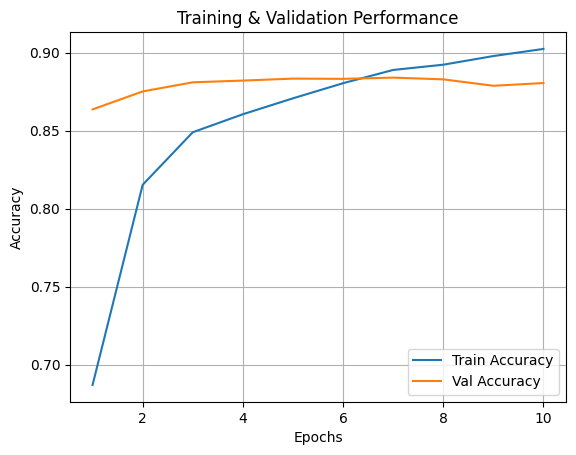

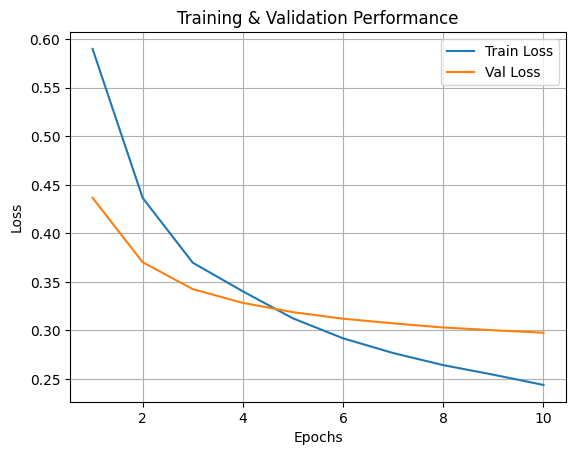

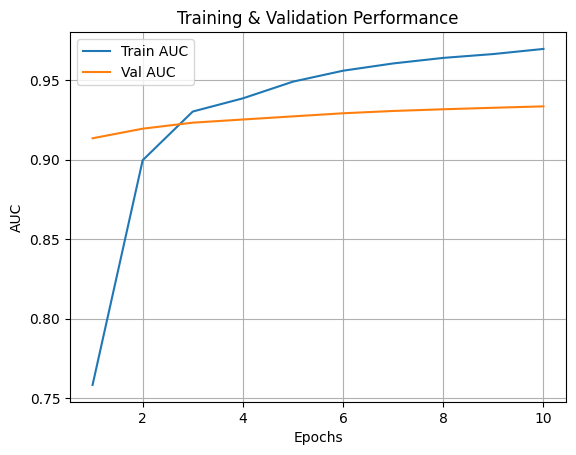

In [11]:

# Visualise training results
epochs = range(1, len(history.history['loss']) + 1)

# Accuracy
plt.plot(epochs, history.history['accuracy'], label='Train Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Val Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Performance')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(epochs, history.history['loss'], label='Train Loss')
plt.plot(epochs, history.history['val_loss'], label='Val Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Performance')
plt.legend()
plt.grid(True)
plt.show()

# AUC
plt.plot(epochs, history.history['auc'], label='Train AUC')
plt.plot(epochs, history.history['val_auc'], label='Val AUC')

plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Training & Validation Performance')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
#### Phase 2

base_model.trainable = True

# Freeze all layers except the last 20
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Compile the model for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=FT_LR),  # Fine-tuning LR
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

# Train / fine-tune the model
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=FT_EPOCHS
)


Epoch 1/5
677/677 ━━━━━━━━━━━━━━━━━━━━ 146s 155ms/step - accuracy: 0.6840 - auc: 0.7639 - loss: 0.5667 - val_accuracy: 0.8923 - val_auc: 0.9465 - val_loss: 0.3317
Epoch 2/5
677/677 ━━━━━━━━━━━━━━━━━━━━ 61s 90ms/step - accuracy: 0.8863 - auc: 0.9613 - loss: 0.2987 - val_accuracy: 0.9003 - val_auc: 0.9477 - val_loss: 0.2919
Epoch 3/5
677/677 ━━━━━━━━━━━━━━━━━━━━ 91s 103ms/step - accuracy: 0.9220 - auc: 0.9804 - loss: 0.2171 - val_accuracy: 0.8998 - val_auc: 0.9486 - val_loss: 0.2769
Epoch 4/5
677/677 ━━━━━━━━━━━━━━━━━━━━ 69s 102ms/step - accuracy: 0.9384 - auc: 0.9879 - loss: 0.1722 - val_accuracy: 0.8915 - val_auc: 0.9522 - val_loss: 0.2630
Epoch 5/5
677/677 ━━━━━━━━━━━━━━━━━━━━ 62s 92ms/step - accuracy: 0.9518 - auc: 0.9926 - loss: 0.1378 - val_accuracy: 0.8870 - val_auc: 0.9543 - val_loss: 0.2624


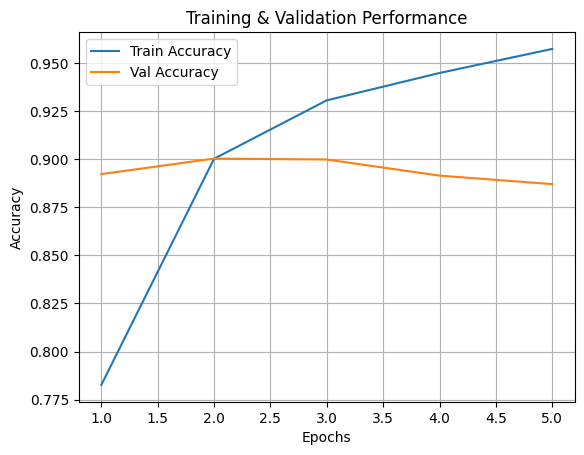

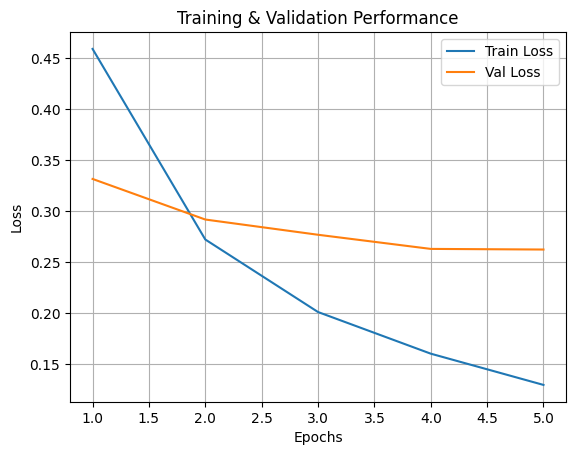

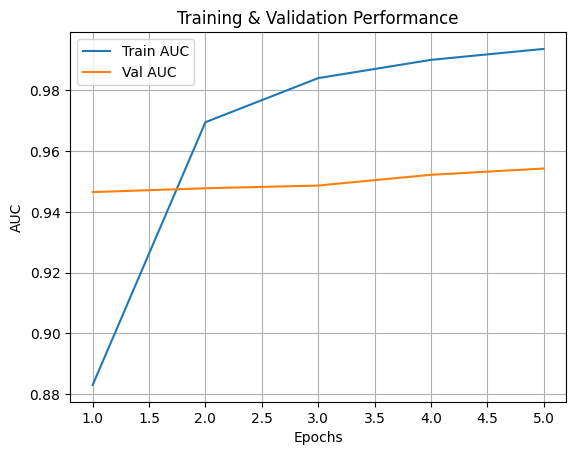

In [19]:

#  Visualise training results
epochs = range(1, len(history_finetune.history['loss']) + 1)

# Accuracy
plt.plot(epochs, history_finetune.history['accuracy'], label='Train Accuracy')
plt.plot(epochs, history_finetune.history['val_accuracy'], label='Val Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Performance')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(epochs, history_finetune.history['loss'], label='Train Loss')
plt.plot(epochs, history_finetune.history['val_loss'], label='Val Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Performance')
plt.legend()
plt.grid(True)
plt.show()

# AUC
plt.plot(epochs, history_finetune.history['auc'], label='Train AUC')
plt.plot(epochs, history_finetune.history['val_auc'], label='Val AUC')

plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Training & Validation Performance')
plt.legend()
plt.grid(True)
plt.show()


In [20]:
### Evaluation Model

# Compute final evaluation metrics for EfficientNetB1 Phase 2
y_true = []
y_pred = []
y_prob = []

for images, labels in val_ds:
    probs = model.predict(images, verbose=0)
    preds = (probs > 0.5).astype(int)

    y_true.extend(labels.numpy())
    y_pred.extend(preds)
    y_prob.extend(probs)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

# Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# Metrics
accuracy  = (tp + tn) / (tp + tn + fp + fn)
precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)
auc       = roc_auc_score(y_true, y_prob)
npv       = tn / (tn + fn)

# Final validation loss (last epoch of fine-tuning)
final_loss = history_finetune.history["val_loss"][-1]

print(f"""
MODEL PERFORMANCE (Validation Set) - EfficientNetB1 Phase 2

Accuracy  : {accuracy:.5f}
Precision : {precision:.5f}
Recall    : {recall:.5f}
F1-Score  : {f1:.5f}
AUC       : {auc:.5f}
NPV       : {npv:.5f}
Loss      : {final_loss:.5f}
""")


MODEL PERFORMANCE (Validation Set) - EfficientNetB1 Phase 2

Accuracy  : 0.88705
Precision : 0.93036
Recall    : 0.87646
F1-Score  : 0.90260
AUC       : 0.95431
NPV       : 0.83135
Loss      : 0.26242



In [21]:
#### Documentation of Model

# Version and base paths
VERSION_NUMBER = VERSION[-2:]

BASE_PATH = f"{VERSION}"
STATS_DIR = os.path.join(BASE_PATH, "Training Stats")

os.makedirs(STATS_DIR, exist_ok=True)

# Save model (correct location + naming)
model.save(f"{MODEL_NAME}-base-model-v{VERSION_NUMBER}.keras")
MODEL_PATH = os.path.join(BASE_PATH,f"{MODEL_NAME}-base-model-v{VERSION_NUMBER}.keras")
model.save(MODEL_PATH)

# Save hyperparameters
hyperparam_text = f"""
Dataset Size = 27,990 Images
Training Size = 21,660 Images (~77.4%)
Validation Size = 6,330 Images (~22.6%)

Input Image Size = {IMG_SIZE}x{IMG_SIZE}
Batch Size = {BATCH_SIZE}

Loss Function = Binary Crossentropy (BCE)
Optimizer = Adam
Learning Rate = {LR}
Fine Tuning Learning Rate = {FT_LR}

1st Training Epochs = {EPOCHS}
Fine Tuning Epochs = {FT_EPOCHS}
"""

with open(os.path.join(BASE_PATH, f"Hyperparameters-v{VERSION_NUMBER}.txt"), "w") as f:
    f.write(hyperparam_text.strip())

# Save logs
def save_log(history, filename):
    with open(os.path.join(STATS_DIR, filename), "w") as f:
        for k, v in history.history.items():
            f.write(f"{k}: {v}\n")

save_log(history, "first_training_log.txt")
save_log(history_finetune, "fine_tuning_log.txt")

# Save plots
import matplotlib.pyplot as plt

def save_plot(history, metric, filename):
    plt.figure()
    plt.plot(history.history[metric], label=f"Train {metric}")
    plt.plot(history.history[f"val_{metric}"], label=f"Val {metric}")
    plt.xlabel("Epochs")
    plt.ylabel(metric.upper())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(STATS_DIR, filename))
    plt.close()

# Phase 1
save_plot(history, "accuracy", "1stTraining_Accuracy.png")
save_plot(history, "loss", "1stTraining_Loss.png")
save_plot(history, "auc", "1stTraining_AUC.png")

# Phase 2
save_plot(history_finetune, "accuracy", "FineTuning_Accuracy.png")
save_plot(history_finetune, "loss", "FineTuning_Loss.png")
save_plot(history_finetune, "auc", "FineTuning_AUC.png")

# Save final evaluation metrics
performance_text = f"""
MODEL PERFORMANCE (Validation Set)

Accuracy  : {accuracy:.5f}
Precision : {precision:.5f}
Recall    : {recall:.5f}
F1-Score  : {f1:.5f}
AUC       : {auc:.5f}
NPV       : {npv:.5f}
Loss      : {final_loss:.5f}
"""

with open(os.path.join(BASE_PATH, "model_performance.txt"), "w") as f:
    f.write(performance_text.strip())

# Put everything into a Zip Folder
ZIP_NAME = f"{VERSION}.zip"

with zipfile.ZipFile(ZIP_NAME, "w", zipfile.ZIP_DEFLATED) as zipf:
    for root, _, file_list in os.walk(BASE_PATH):
        for file in file_list:
            full_path = os.path.join(root, file)
            arcname = os.path.relpath(full_path, BASE_PATH)
            zipf.write(full_path, arcname)

files.download(ZIP_NAME)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Datasets  EfficientNet-B1-base-model-v01.keras	Models	Version-01
'EfficientNet-B1 model'
